In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from utils.visualizer import Visualizer
from IPython.display import SVG, display
from sklearn.metrics import precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle
import sklearn
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: TITAN X (Pascal) (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5105)


In [3]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

# Build the dataset

In [4]:
dataset = np.load('../data/artificial_dataset1.npy')
targets = np.load('../data/artificial_dataset1_targets.npy')

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 350, 500), targets.reshape(-1, 1, 350, 500), random_state=42)

# Build the network

In [16]:
from models.vgg import VGG

In [29]:
vgg = VGG([1, 350, 500])

In [30]:
vgg.perform_compilation(5)

<IPython.core.display.Javascript object>


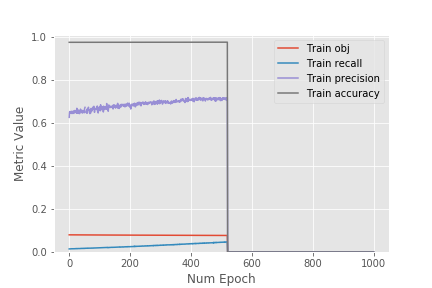

<IPython.core.display.Javascript object>


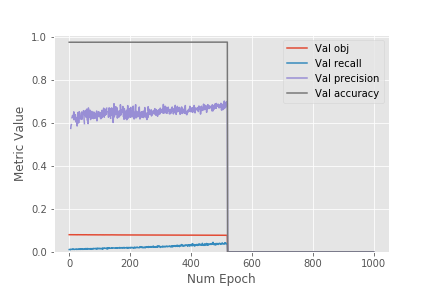

Epoch 1 of 1000 took 21.009s
Epoch 2 of 1000 took 21.032s
Epoch 3 of 1000 took 21.104s
Epoch 4 of 1000 took 21.164s
Epoch 5 of 1000 took 21.210s
Epoch 6 of 1000 took 21.235s
Epoch 7 of 1000 took 21.309s
Epoch 8 of 1000 took 21.395s
Epoch 9 of 1000 took 21.378s
Epoch 10 of 1000 took 21.564s
Epoch 11 of 1000 took 21.527s
Epoch 12 of 1000 took 21.554s
Epoch 13 of 1000 took 21.608s
Epoch 14 of 1000 took 21.524s
Epoch 15 of 1000 took 21.568s
Epoch 16 of 1000 took 21.547s
Epoch 17 of 1000 took 21.771s
Epoch 18 of 1000 took 21.558s
Epoch 19 of 1000 took 21.689s
Epoch 20 of 1000 took 21.751s
Epoch 21 of 1000 took 21.492s
Epoch 22 of 1000 took 21.537s
Epoch 23 of 1000 took 21.540s
Epoch 24 of 1000 took 21.691s
Epoch 25 of 1000 took 21.579s
Epoch 26 of 1000 took 21.663s
Epoch 27 of 1000 took 21.521s
Epoch 28 of 1000 took 21.645s
Epoch 29 of 1000 took 21.602s
Epoch 30 of 1000 took 21.528s
Epoch 31 of 1000 took 21.661s
Epoch 32 of 1000 took 21.670s
Epoch 33 of 1000 took 21.562s
Epoch 34 of 1000 to

In [ ]:
learn(vgg,
      X_y,
      watches=['obj', 'recall', 'precision', 'accuracy'],
      num_epochs=1000, batch_size=100
)

In [35]:
vgg = VGG([1, 350, 500])
vgg.perform_compilation(4)

In [36]:
vgg.evaluate(X_y[1][:100], X_y[-1][:100])

{'accuracy': array(0.5123502304147466),
 'obj': array(0.6927528381347656, dtype=float32),
 'precision': array(0.0179325882345438),
 'recall': array(0.6670547127723694, dtype=float32),
 'total_complexity': array(11784459)}

<IPython.core.display.Javascript object>


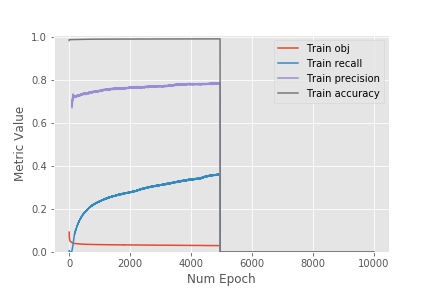

<IPython.core.display.Javascript object>


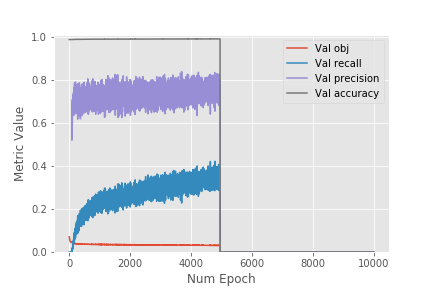

Epoch 1 of 10000 took 20.696s
Epoch 2 of 10000 took 20.758s
Epoch 3 of 10000 took 20.792s
Epoch 4 of 10000 took 20.892s
Epoch 5 of 10000 took 20.907s
Epoch 6 of 10000 took 20.970s
Epoch 7 of 10000 took 21.007s
Epoch 8 of 10000 took 21.141s
Epoch 9 of 10000 took 21.078s
Epoch 10 of 10000 took 21.202s
Epoch 11 of 10000 took 21.440s
Epoch 12 of 10000 took 21.122s
Epoch 13 of 10000 took 21.334s
Epoch 14 of 10000 took 21.193s
Epoch 15 of 10000 took 21.180s
Epoch 16 of 10000 took 21.250s
Epoch 17 of 10000 took 21.162s
Epoch 18 of 10000 took 21.215s
Epoch 19 of 10000 took 21.155s
Epoch 20 of 10000 took 21.182s
Epoch 21 of 10000 took 21.128s
Epoch 22 of 10000 took 21.363s
Epoch 23 of 10000 took 21.118s
Epoch 24 of 10000 took 21.146s
Epoch 25 of 10000 took 21.313s
Epoch 26 of 10000 took 21.163s
Epoch 27 of 10000 took 21.150s
Epoch 28 of 10000 took 21.249s
Epoch 29 of 10000 took 21.183s
Epoch 30 of 10000 took 21.308s
Epoch 31 of 10000 took 21.244s
Epoch 32 of 10000 took 21.148s
Epoch 33 of 10000

In [ ]:
learn(vgg,
      X_y,
      watches=['obj', 'recall', 'precision', 'accuracy'],
      num_epochs=10000, batch_size=100
)

In [43]:
vgg = VGG([1, 350, 500])
vgg.perform_compilation(3)

In [44]:
vgg.evaluate(X_y[1][:100], X_y[-1][:100])

{'accuracy': array(0.029317329332333084),
 'obj': array(1.1875486373901367, dtype=float32),
 'precision': array(0.008750331588089466),
 'recall': array(0.9567408561706543, dtype=float32),
 'total_complexity': array(11018666)}

<IPython.core.display.Javascript object>


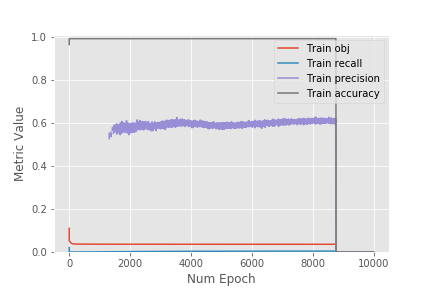

<IPython.core.display.Javascript object>


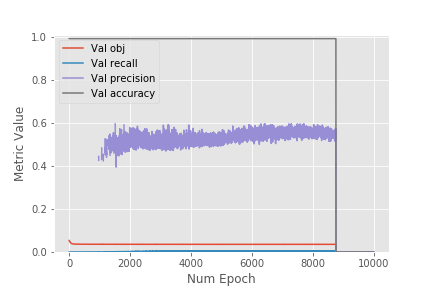

Epoch 1 of 10000 took 20.300s
Epoch 2 of 10000 took 20.298s
Epoch 3 of 10000 took 20.355s
Epoch 4 of 10000 took 20.418s
Epoch 5 of 10000 took 20.463s
Epoch 6 of 10000 took 20.479s
Epoch 7 of 10000 took 20.539s
Epoch 8 of 10000 took 20.659s
Epoch 9 of 10000 took 20.727s
Epoch 10 of 10000 took 20.900s
Epoch 11 of 10000 took 20.896s
Epoch 12 of 10000 took 20.958s
Epoch 13 of 10000 took 20.899s
Epoch 14 of 10000 took 20.938s
Epoch 15 of 10000 took 20.999s
Epoch 16 of 10000 took 21.064s
Epoch 17 of 10000 took 20.969s
Epoch 18 of 10000 took 20.934s
Epoch 19 of 10000 took 21.058s
Epoch 20 of 10000 took 21.165s
Epoch 21 of 10000 took 21.072s
Epoch 22 of 10000 took 21.017s
Epoch 23 of 10000 took 21.170s
Epoch 24 of 10000 took 21.114s
Epoch 25 of 10000 took 21.173s
Epoch 26 of 10000 took 21.054s
Epoch 27 of 10000 took 21.133s
Epoch 28 of 10000 took 21.097s
Epoch 29 of 10000 took 20.891s
Epoch 30 of 10000 took 21.091s
Epoch 31 of 10000 took 21.078s
Epoch 32 of 10000 took 21.012s
Epoch 33 of 10000

In [ ]:
learn(vgg,
      X_y,
      watches=['obj', 'recall', 'precision', 'accuracy'],
      num_epochs=10000, batch_size=100
)

In [39]:
import theano

get_target = theano.function([vgg.targets], vgg.target_output)

def draw_precision_recall(network, x_val, y_val):
    prediction = network.predict(x_val)
    target = get_target(y_val)

    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc='best')
    plt.show()
    
    for r in [0.90, 0.95, 0.99, 0.999]:
        print 'Recall:', recall[np.max(np.where(recall >= r))]
        print 'Precision:', precision[np.max(np.where(recall >= r))]
        print

In [45]:
vgg.load('../weights', 'vgg5')

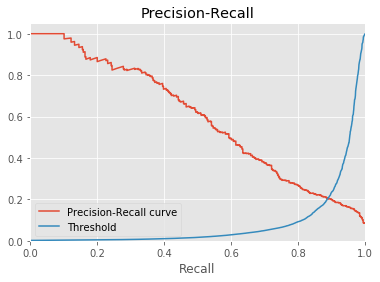

Recall: 0.901041666667
Precision: 0.2001156738

Recall: 0.950520833333
Precision: 0.164414414414

Recall: 0.9921875
Precision: 0.111501316945

Recall: 1.0
Precision: 0.0849181777974



In [46]:
%matplotlib inline
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])

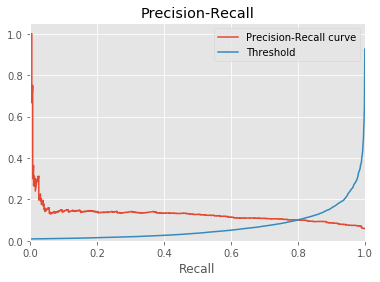

Recall: 0.901041666667
Precision: 0.0865649236928

Recall: 0.950520833333
Precision: 0.0762163290875

Recall: 0.9921875
Precision: 0.0637123745819

Recall: 1.0
Precision: 0.0590315142198



In [35]:
%matplotlib inline
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])

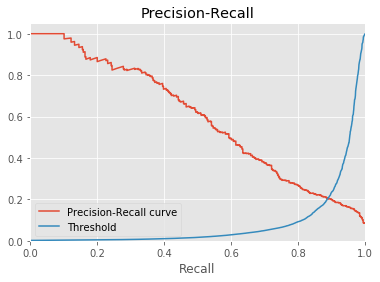

Recall: 0.901041666667
Precision: 0.2001156738

Recall: 0.950520833333
Precision: 0.164414414414

Recall: 0.9921875
Precision: 0.111501316945

Recall: 1.0
Precision: 0.0849181777974



In [94]:
%matplotlib inline
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])

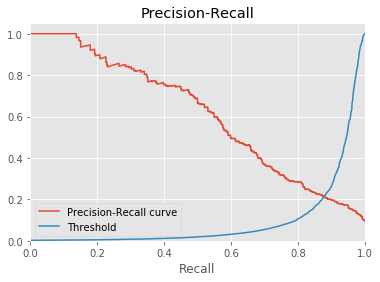

Recall: 0.901041666667
Precision: 0.197940503432

Recall: 0.950520833333
Precision: 0.171200750469

Recall: 0.9921875
Precision: 0.116727941176

Recall: 1.0
Precision: 0.0962406015038



In [101]:
%matplotlib inline
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])

In [46]:
np.savez(os.path.join('../weights', 'vgg4'), *lasagne.layers.get_all_param_values(vgg.network))

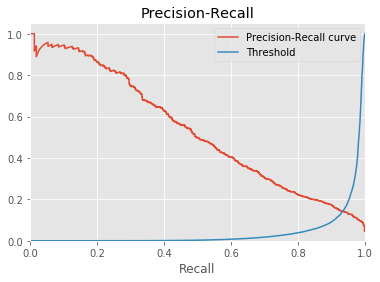

Recall: 0.901047729919
Precision: 0.173115634086

Recall: 0.951105937136
Precision: 0.129313073758

Recall: 0.990686845169
Precision: 0.092039800995

Recall: 1.0
Precision: 0.0457060764074



In [40]:
%matplotlib inline
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])

In [ ]:
np.savez(os.path.join('../weights', 'vgg3'), *lasagne.layers.get_all_param_values(vgg.network))

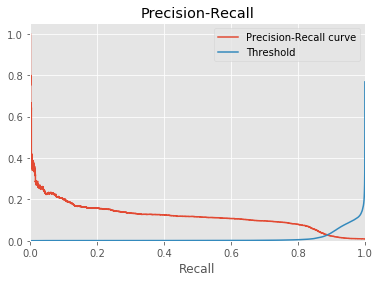

Recall: 0.90004199916
Precision: 0.0229967699357

Recall: 0.95002099958
Precision: 0.0120798487616

Recall: 0.990340193196
Precision: 0.0096489864063

Recall: 0.9991600168
Precision: 0.00919590880627



In [48]:
%matplotlib inline
get_target = theano.function([vgg.targets], vgg.target_output)
draw_precision_recall(vgg, X_y[1][:100], X_y[-1][:100])